# Code interpreter with Qwen2.5-Coder-32B-Instruct

This example uses the [E2B SDK](https://github.com/e2b-dev/code-interpreter) as a code interpreter for [Qwen2.5-Coder-32B-Instruct](https://fireworks.ai/models/fireworks/qwen2p5-coder-32b-instruct) on [Fireworks AI](https://x.com/FireworksAI_HQ/status/1856146229690019948).

The code generated by the LLM runs in a [E2B secure cloud sandbox](https://e2b.dev/docs/sandbox/overview).
>

### 1. Installations
First, we install Fireworks, OpenAI, and the E2B Code Interpreter SDK.

In [193]:
%pip install --upgrade fireworks-ai openai e2b_code_interpreter==1.0.0 python-dotenv==1.0.1


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 2. Imports and API keys

You need to get your API keys and save them in .env file. You can copy and rename the .env.template file. We import all necessary libraries.

This is what you should put in the .env file:

```sh
# TODO: Get your Fireworks API key from https://fireworks.ai/api-keys
FIREWORKS_API_KEY = "your_api_key"

# TODO: Get your E2B API key from https://e2b.dev/docs
E2B_API_KEY = "your_api_key"
```

In [194]:
import openai
import json
import sys
import os
import re
from dotenv import load_dotenv
load_dotenv()

FIREWORKS_API_KEY = os.getenv("FIREWORKS_API_KEY")
E2B_API_KEY = os.getenv("E2B_API_KEY")

### 3. Prompts setup

Now we specify a system prompt, assigning a role to LLM. We define a function to extract code blocks formatted in Markdown style from text.

In [195]:
SYSTEM_PROMPT = """
## your job & context
you are a python data scientist. you are given tasks to complete and you run python code to solve them.
You DO NOT MAKE SYNTAX MISTAKES OR FORGET ANY IMPORTS
- the python code runs in jupyter notebook.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment.
"""

client = openai.OpenAI(
    base_url = "https://api.fireworks.ai/inference/v1",
    api_key = FIREWORKS_API_KEY
)

def match_code_blocks(text):
    pattern = re.compile(r'```(?:python)?[\n\r](.*?)```', re.DOTALL)
    return pattern.findall(text)

### 4. Defining the function for running the AI-generated code

We define the `code_interpret` function that uses the [E2B SDK](https://e2b.dev/docs) to run AI-generated Python code.

We will use `run_code` to execute the AI-generated code inside the code interpreter sandbox. 

In [196]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.run_code(
    code,
    # Stream stdout and stderr from the Code Interpreter
    on_stdout=lambda stdout: print("[Code Interpreter]", stdout),
    on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
    # You can also stream code execution results
    # on_result=...
  )

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec

### 5. Getting agent's response

Now we define a ```chat``` function that uses the model to get agent's response to the user's task. If the response contains code, the code interpreter by E2B is used to securely run the code.

In [197]:
def chat(e2b_code_interpreter, user_message):
    print(f"\n{'='*50}\nUser Message: {user_message}\n{'='*50}")
    
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_message}
    ]

    response = client.chat.completions.create(
        #model="accounts/fireworks/models/firefunction-v2",
        model="accounts/fireworks/models/qwen2p5-coder-32b-instruct",
        messages=messages,
        # tools=tools,
        tool_choice="auto"
    )

    # Extract the assistant's message content
    content = response.choices[0].message.content

    # Use the assistant's message content for code extraction
    code_results = []
    code_blocks = match_code_blocks(content)
    for code in code_blocks:
        print(f"Code to run: {code}")

        code_interpreter_results = code_interpret(e2b_code_interpreter, code)
        print(f"Code Interpreter Result: {code_interpreter_results}")
        code_results.append(code_interpreter_results)

    return code_results

### 6. Printing the output

Finally we get the task result, calling the ```chat``` function.

Read more about how the execution with E2B SDK looks like [here](https://e2b.dev/docs).


User Message: Plot a 3D chart of sin x cos y please.
Code to run: import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of x and y values
x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
y = np.linspace(-2 * np.pi, 2 * np.pi, 100)
X, Y = np.meshgrid(x, y)

# Calculate Z values
Z = np.sin(X) * np.cos(Y)

# Create the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surface = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Add a color bar which maps values to colors
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show plot
plt.show()

Running code interpreter...
[Code Interpreter] /usr/local/lib/python3.10/site-packages/pydantic/main.py:390: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue: Expected `LineChart` but got `Chart` with value `Chart(type=<ChartType.UNK.

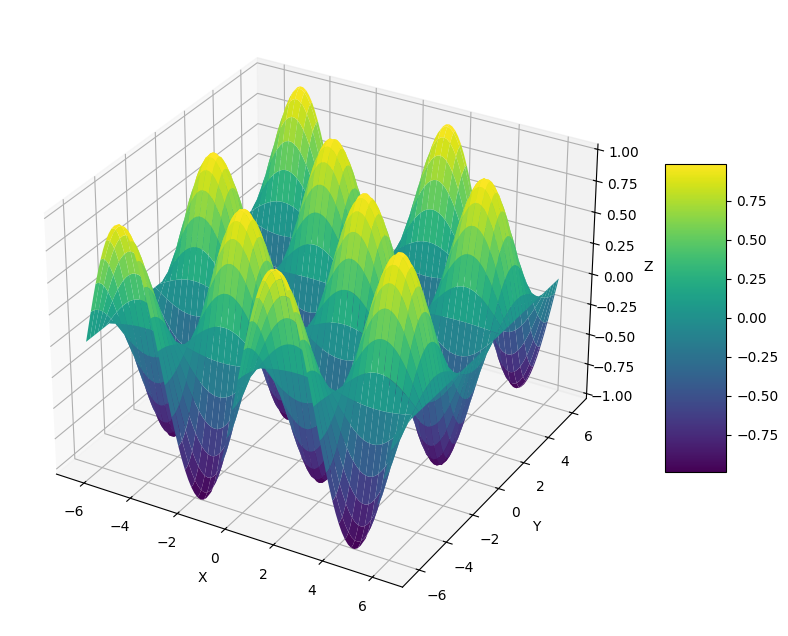

In [198]:
from e2b_code_interpreter import Sandbox

with Sandbox(api_key=E2B_API_KEY) as code_interpreter:
  all_code_blocks_results = chat(
    code_interpreter,
    #"Calculate value of pi using monte carlo method. Use 1000 iterations. Visualize all points of all iterations on a single plot, a point inside the unit circle should be green, other points should be gray.",
    "Plot a 3D chart of sin x cos y please.",
  )

  if all_code_blocks_results is None:
    print("No output from the code interpreter. Did the LLM generate any code?")
    sys.exit(1)

  for result in all_code_blocks_results:
    # Access stdout
    print("Stdout:", result.logs.stdout)
    # Access stderr
    print("Stderr:", result.logs.stderr)

    # Access any runtime errors
    print("AI-generated Python runtime error:", result.error)

    # Access any results of code execution - charts, interpreter last line, images, etc.
    print("Results:", result.results)
    if len(result.results) == 0:
      sys.exit(0)

result.results[0]